# Continuous Control

---

*Jun Zhu, zhujun981661@gmail.com, 08.2020*

In this notebook, I present the solution for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# !pip install matplotlib

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from ddpg_agent import DdpgAgent
from utilities import check_environment, play, plot_score_history, plot_losses

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
brain_name, state_space, action_space = check_environment(env)
brain_name

Brain name:  ReacherBrain
Brain:  Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Number of agents: 1
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length

'ReacherBrain'

### 3. Take Random Actions in the Environment

In [5]:
# play(env, brain_name, continuous=True)

### 4. Train  a DDPG (deep deterministic policy gradient) agent

The DDPG algorithm proposed in this [paper](https://arxiv.org/pdf/1509.02971.pdf) was implemented. DDPG is an actor-critic, model-free algorithm based on the deterministic policy gradient that can operate over **continuous action space**.

In [6]:
def init_layer(layer):
    layer.weight.data.uniform_(-3e-3, 3e-3)
    layer.bias.data.uniform_(-3e-3, 3e-3)


class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._fc1 = nn.Linear(state_space, 256)
        self._fc2 = nn.Linear(256, 1024)
        self._fc3 = nn.Linear(1024, 256)

        self._fc_final = nn.Linear(256, action_space)
        init_layer(self._fc_final)

    def forward(self, state):
        x = state
        for fc in (self._fc1, self._fc2, self._fc3):
            x = F.leaky_relu(fc(x), negative_slope=0.01)
        
        return torch.tanh(self._fc_final(x))
    

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._fc1 = nn.Linear(state_space + action_space, 256)
        self._fc2 = nn.Linear(256, 1024)
        self._fc3 = nn.Linear(1024, 256)

        self._fc_final = nn.Linear(256, 1)
        init_layer(self._fc_final)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        
        for fc in (self._fc1, self._fc2, self._fc3):
            x = F.leaky_relu(fc(x), negative_slope=0.01)
            
        return self._fc_final(x)

In [7]:
target_score = 30

# initialize the agent
agent = DdpgAgent(action_space, (Actor(), Critic()), replay_memory_size=int(5e5))

# train the agent with given hyperparameters (remove ./ddpg_checkpoint.pth to train a new model from scratch)
scores, losses_actor, losses_critic = agent.train(env,
    theta=0.15,  # Ornstein-Uhlenbeck process constant
    sigma=0.20,  # Ornstein-Uhlenbeck process constant
    decay_rate=0.995,  # noise decay rate
    tau=0.001,  # soft update rate of the target network
    gamma=0.99,  # discount factor
    learning_rate=(5e-4, 5e-4),  # learning rates of actor and critic models
    weight_decay=(1e-5, 1e-5),  # L2 penalties of actor and critic models
    batch_size=128,  # mini batch size
    n_episodes=500,
    target_score=target_score + 0.5,
    output_frequency=10)

Loaded existing model ended at epoch: 199 with averagescore of    30.55
Score of the current model    30.55 is already higher than the target score 30.5!


Visualize the histories of score and losses.

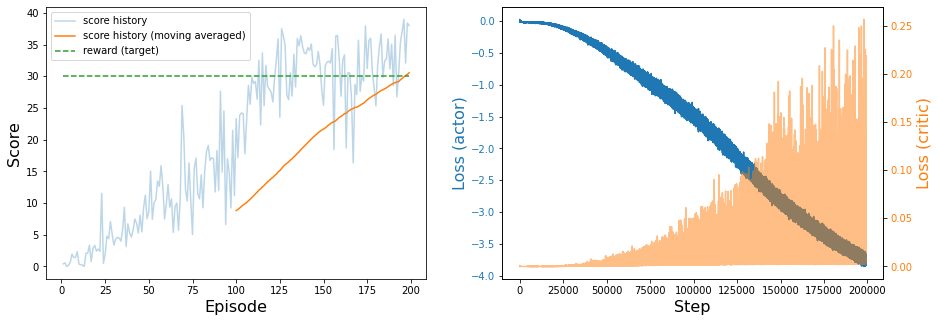

In [8]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_score_history(ax[0], scores, target_score)
plot_losses(ax[1], losses_actor, 'Loss (actor)', losses_critic, 'Loss (critic)')

Show the score of successive 10 plays using the optimal policy.

In [9]:
play(env, brain_name, agent, repeats=10)

Score of play 01:      34.4000
Score of play 02:      11.7200
Score of play 03:      35.8400
Score of play 04:      35.3400
Score of play 05:      29.6000
Score of play 06:      38.6700
Score of play 07:      36.3600
Score of play 08:      35.8300
Score of play 09:      34.7100
Score of play 10:      36.4300


In [10]:
env.close()

### 5. Further improvement

Use the second environment with 20 agents and implement [PPO](https://arxiv.org/pdf/1707.06347.pdf), [A3C](https://arxiv.org/pdf/1602.01783.pdf), and [D4PG](https://openreview.net/pdf?id=SyZipzbCb) that use multiple (non-interacting, parallel) copies of the same agent to distribute the task of gathering experience.